## Imports

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from models import utils, arx, hammerstein

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Extracting Data


In [3]:
data1 = utils.read_mat("/home/matthias/WS_all/dbm/raw/ex3_handout/ex3_system1_data.mat")
data2 = utils.read_mat("/home/matthias/WS_all/dbm/raw/ex3_handout/ex3_system2_data.mat")

display(data1.keys())
display(data2.keys())

dict_keys(['__header__', '__version__', '__globals__', 'None', 'README', 't1', 't2', 'u1', 'u2', 'y1', 'y2', '__function_workspace__'])

dict_keys(['__header__', '__version__', '__globals__', 'README', 't1', 't2', 't3', 'u1', 'u2', 'u3', 'y1', 'y2', 'y3'])

In [4]:
# Data
t = jnp.array(data2.t1)
y = jnp.array(data2.y1)
u = jnp.array(data2.u1)


t2 = jnp.array(data2.t2)
y2 = jnp.array(data2.y2)
u2 = jnp.array(data2.u2)

t3 = jnp.array(data2.t3)
y3 = jnp.array(data2.y3)
u3 = jnp.array(data2.u3)

## Plot Data


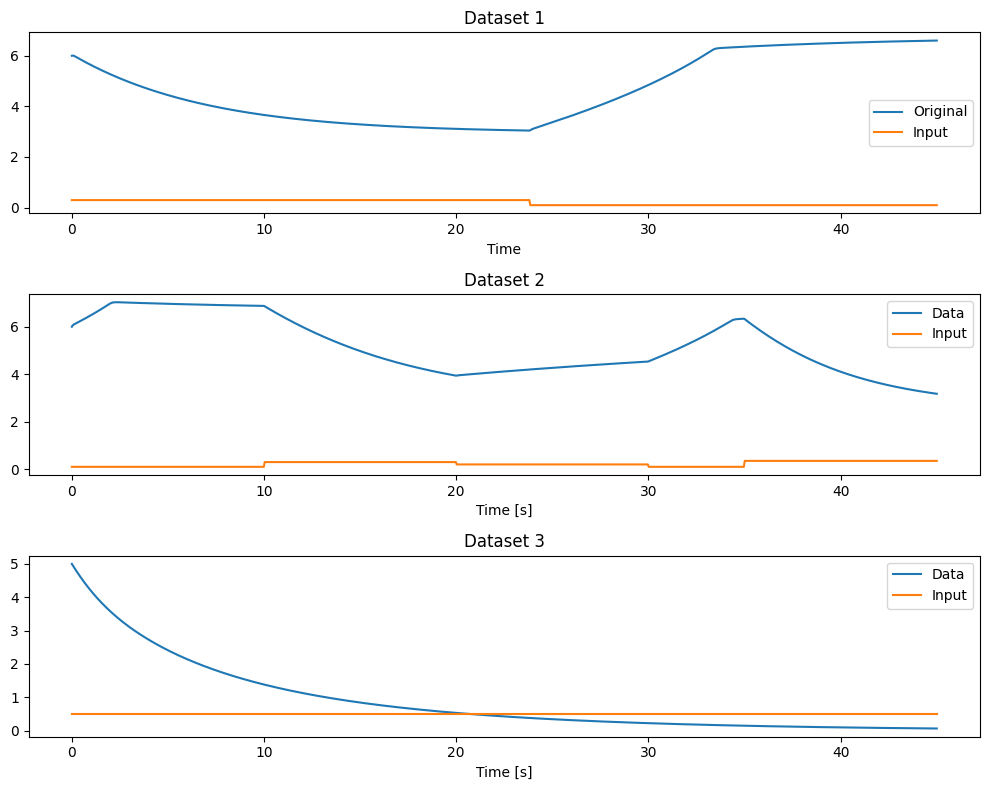

In [5]:
fig, ax = plt.subplots(3,1,figsize=(10, 8))

ax[0].plot(t, y,label='Original')
ax[0].plot(t, u, label='Input')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_title('Dataset 1')

ax[1].plot(t2,y2, label='Data')
ax[1].plot(t2, u2, label='Input')
ax[1].legend()
ax[1].set_xlabel('Time [s]')
ax[1].set_title('Dataset 2')

ax[2].plot(t3,y3, label='Data')
ax[2].plot(t3, u3, label='Input')
ax[2].legend()
ax[2].set_xlabel('Time [s]')
ax[2].set_title('Dataset 3')
plt.tight_layout()
plt.show()

## Create Model


In [7]:
na_range = jnp.array([3,6])
nb_range = jnp.array([3,6])
order_ = jnp.array([2,7])
num_polys = jnp.array([1,3])
scalers_poly = jnp.array([0.2,0.8])

y_new = jnp.concatenate([y,y3]).flatten()
u_new = jnp.concatenate([u,u3]).flatten()


p_hat,loss, func, order, na,nb = hammerstein.optimize(y_new,u_new,(1,6),(1,6),(5,6),(1,3),(0.25,0.7))

Total parameters: 4250
Progress: 0.02 %
Current iteration time: 0.32s, average: 0.16 seconds
Progress: 2.38 %
Current iteration time: 0.19s, average: 0.18 seconds
Progress: 4.73 %
Current iteration time: 0.29s, average: 0.34 seconds
Progress: 7.08 %
Current iteration time: 0.43s, average: 0.40 seconds
Progress: 9.44 %
Current iteration time: 0.34s, average: 0.34 seconds
Progress: 11.79 %
Current iteration time: 0.40s, average: 0.38 seconds
Progress: 14.14 %
Current iteration time: 0.77s, average: 0.66 seconds
Progress: 16.49 %
Current iteration time: 0.49s, average: 0.50 seconds
Progress: 18.85 %
Current iteration time: 0.63s, average: 0.60 seconds
Progress: 21.20 %
Current iteration time: 0.35s, average: 0.34 seconds
Progress: 23.55 %
Current iteration time: 0.25s, average: 0.25 seconds
Progress: 25.91 %
Current iteration time: 0.46s, average: 0.45 seconds
Progress: 28.26 %
Current iteration time: 0.39s, average: 0.40 seconds
Progress: 30.61 %
Current iteration time: 0.65s, average: 0

In [10]:
print("Loss", loss)
print("Func", func)
print("Order", order)
print("NA", na, " NB", nb)

Loss 0.117759004
Func functools.partial(<PjitFunction of <function _polynomial at 0x77874c501bc0>>, array=Array([0.475 , 0.5875, 0.3625], dtype=float32))
Order 5
NA 2  NB 3


## Predict 

In [13]:
y1_pred = hammerstein.simulate(y.flatten()[:na], u.flatten(), na,nb, order, func, p_hat)
y2_pred = hammerstein.simulate(y2.flatten()[:na], u2.flatten(), na, nb, order, func, p_hat)
y3_pred = hammerstein.simulate(y3.flatten()[:na], u3.flatten(), na, nb, order, func, p_hat)


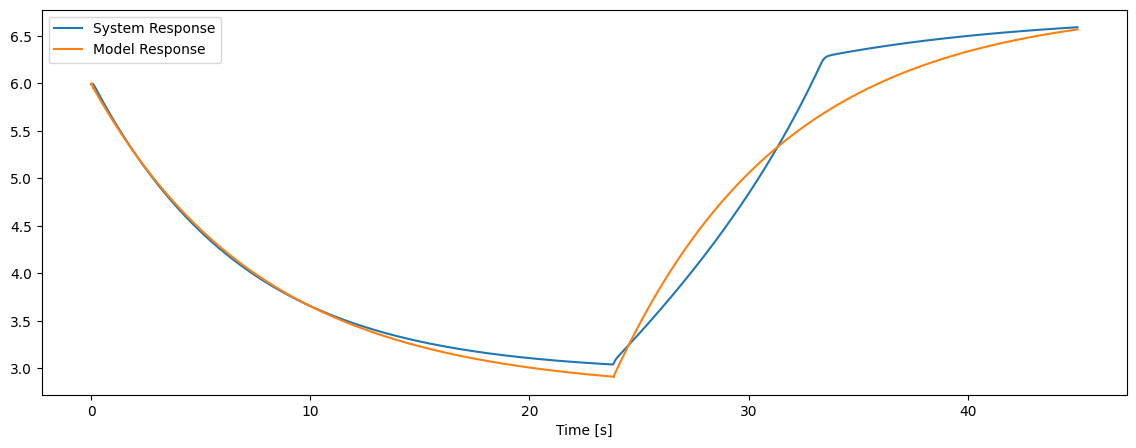

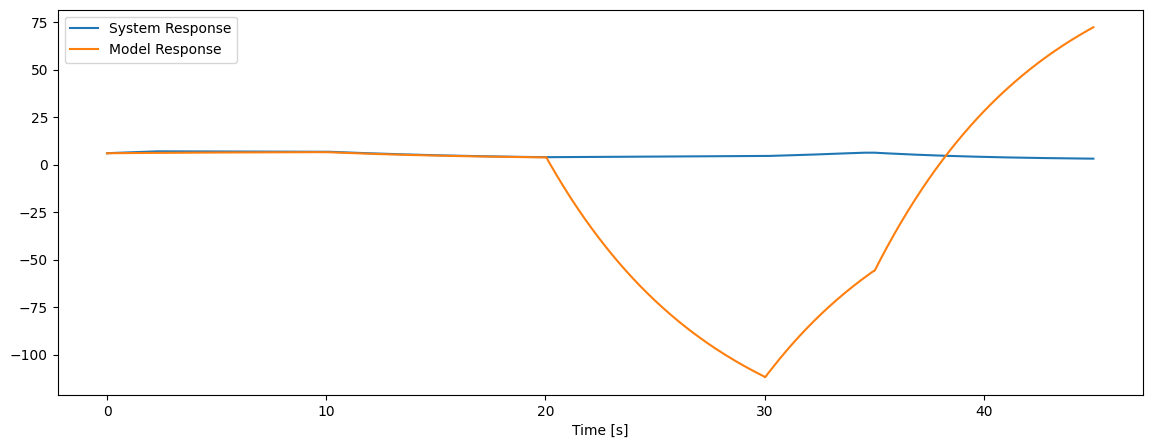

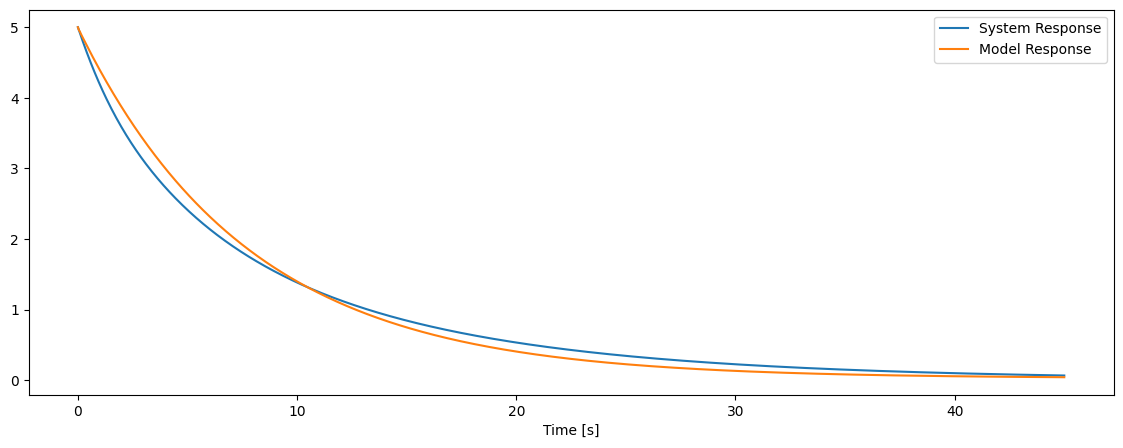

In [14]:
plt.figure(figsize=(14, 5))
plt.plot(t,y, label="System Response")
plt.xlabel("Time [s]")
plt.plot(t, y1_pred,label="Model Response")
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(t2,y2, label="System Response")
plt.xlabel("Time [s]")
plt.plot(t2, y2_pred,label="Model Response")
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(t3,y3, label="System Response")
plt.xlabel("Time [s]")
plt.plot(t3, y3_pred,label="Model Response")
plt.legend()
plt.show()
